In [120]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from pymongo import MongoClient
from scipy.spatial.distance import cosine
from IPython.display import Image, display, Markdown


import os
from dotenv import load_dotenv
import pandas as pd

load_dotenv()

True

In [100]:
emb_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
model = ChatGroq(model='llama3-8b-8192', api_key=os.environ['GROQ_API_KEY'])

websearch_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

client = MongoClient("mongodb://localhost:27017/")
collection = client["netsol_db"]["financial_statements"]


In [101]:
class AgentState(TypedDict):
    query: str = None
    answer: str = None
    relevance_count: int = 0
    document_relevant: bool = False
    context: str = None

In [102]:
def router(state: AgentState) -> AgentState:
    query = state["query"]
    prompt = f"""
        You are an intelligent assistant. Decide the best source for the following query: 
        - If the query is about anything about Netsol, choose "document_search".
        - If the query is about finance of a company even if the name "Netsol" is not mentioned, choose "document_search".
        - If the query is about recent events, general information, or open-ended topics, choose "internet_search".
        Query: {query}
        Respond with either "internet_search" or "document_search" only. 
    """
    response = model.invoke(prompt)
    decision = response.content.strip().lower()

    if "internet_search" in decision:
        state["answer"] = "internet_search"
    elif "document_search" in decision:
        state["answer"] = "document_search"
    else:
        raise ValueError(f"Unexpected LLM response: {response}")
    return state


In [103]:
def internet_search(state: AgentState) -> AgentState:
    print("Calling from internet search")

    resps = websearch_tool.invoke({"query": state["query"]})
    context = ""
    for i,resp in enumerate(resps):
        context += f"""
            Source {i+1}:
            "{resp}"\n\n
        """
    prompt = f"""
        The user asked: {state['query']}
        
        The relevant context is:
        {context}
    """
    resp = model.invoke(prompt)
    state["answer"] = resp.content
    state["context"] = context
    return state

In [117]:
def rewrite_query(state: AgentState) -> AgentState:
    print("Calling from rewrite query")
    prompt = f"""
        The user asked: {state['query']}

        Based on the context provided below, the original query seems to be irrelevant or too broad. Please suggest a more relevant and specific query that would yield better results based on the documents' content.

        Context:
        {state["context"]}

        Respond with modified query only, don't add extra text
    """
    resp = model.invoke(prompt)
    state['query'] = resp.content

    print("QUERY MODIFIED:", state["query"])

    return state


In [105]:
def document_relevance(state: AgentState) -> AgentState:
    print("Checking response relevance")

    prompt = f"""
        Does "{state['answer']}" answers the question "{state['query']}"?

        Respond with either "yes" or "no" only. 
    """

    resp = model.invoke(prompt)
    if not "yes" in resp.content:
        state["document_relevant"] = False
        if not "relevance_count" in state.keys():
            state["relevance_count"] = 0
        state["relevance_count"] += 1
        if state["relevance_count"] < 3:
            state['answer'] = "rewrite_query"
        else:
            state["answer"] = "internet_search"
    else:
        state["document_relevant"] = True

    return state


In [106]:
def document_search(state: AgentState) -> AgentState:
    print("Calling from document search")

    query_vector = emb_model.embed_query(state["query"])


    top_k = 3

    max_sim = [-1]*top_k
    top_document = [None]*top_k

    documents = collection.find()

    for doc in documents:
        similarity = 1 - cosine(query_vector,doc["values"])
        for i,sim in enumerate(max_sim):
            if similarity > sim:
                top_document[i] = doc
                max_sim[i] = similarity
                break
    

    context = ""
    for i,resp in enumerate(top_document):
        context += f"""
            Source {i+1}:
            "{resp['metadata']['text']}"\n\n
        """
    prompt = f"""
        The user asked: {state['query']}
        
        The relevant context is:
        {context}
    """
    resp = model.invoke(prompt)
        
    state["answer"] = resp.content
    state["context"] = context
    return state

In [118]:
workflow = StateGraph(AgentState)

workflow.add_node("router", router)
workflow.add_node("internet_search", internet_search)
workflow.add_node("document_search", document_search)
workflow.add_node("document_relevance", document_relevance)
workflow.add_node("rewrite_query", rewrite_query)

workflow.add_edge(START,"router")
workflow.add_conditional_edges("router", lambda state: state["answer"])
workflow.add_edge("internet_search",END)
workflow.add_edge("document_search","document_relevance")
workflow.add_conditional_edges("document_relevance", lambda state: END if state["document_relevant"] else state["answer"])
workflow.add_edge("rewrite_query", "document_search")

graph = workflow.compile()

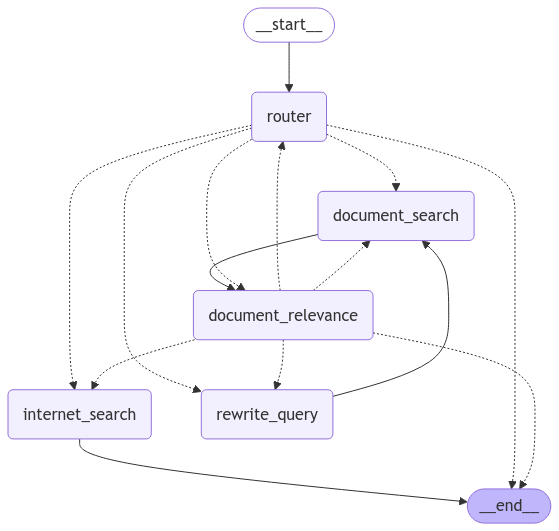

In [108]:

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Test Runs

In [109]:
resp = graph.invoke({"query": "How trump family become rich?"})

display(Markdown(resp["answer"]))

Calling from internet search


Based on the provided sources, here's a summary of how the Trump family became rich:

1. Frederick Trump, Donald Trump's grandfather, arrived in the United States during the Gold Rush of the late 1800s with limited money. He worked hard and became a successful entrepreneur, striking it rich during this period.
2. Donald Trump's father, Fred Trump, was likely the driving force behind the family's real estate business. He used his negotiating skills to secure a 40-year tax break for a hotel project in Manhattan, which saved the family $160 million. Fred Trump was known for being frugal and saving every penny possible.
3. Donald Trump himself has continued this legacy of frugality and strategic business moves. He has been willing to put his name on various products and projects, such as buildings, steaks, and ties, which has contributed to the success of the Trump Organization.

It's worth noting that the exact details of the Trump family's wealth and business dealings are not publicly known due to a lack of transparency and the absence of President Trump's tax returns. However, based on the available information, it appears that a combination of hard work, smart business decisions, and strategic partnerships have contributed to the Trump family's wealth.

In [110]:
resp = graph.invoke({"query": "What does Netsol do?"})

display(Markdown(resp["answer"]))

Calling from document search
Checking response relevance


Based on the provided sources, it appears that NETSOL Technologies Limited is a Pakistani company that is engaged in the development and sale of computer software and allied services. The company has multiple business units located in different parts of Pakistan, as well as a branch office in Indonesia.

The company has an open-door policy, which encourages employees to communicate with senior management and provide suggestions, voice grievances, or discuss any matters related to the company. The company also has an audit committee that allows employees to report any monetary irregularities or suspicious activities anonymously.

In terms of corporate social responsibility, NETSOL has several initiatives in place. The company has a National Education Support Program that covers the educational expenses of its support staff's children, and it has also provided financial support to the DIL School (Development in Literacy Foundation) to provide quality education to underprivileged children.

Additionally, the company has a policy of paying government taxes in a timely and transparent manner, and it has contributed over 20,000 patients to over the year.

Overall, NETSOL Technologies Limited appears to be a company that is committed to its employees, customers, and the community, and it has multiple initiatives in place to support education, healthcare, and corporate social responsibility.

In [111]:

resp = graph.invoke({"query": "what is the gross profit margin of 2024"})

display(Markdown(resp["answer"]))

Calling from internet search


Based on the provided sources, it appears that the question is asking about the gross profit margin of 2024 for a specific industry, but the sources do not provide a direct answer. Here's a breakdown of what each source provides:

Source 1: This source does not provide a gross profit margin specifically for 2024, but it does mention the profit margin for the entire industry in 2024, which is 45.0%.

Source 2: This source does not provide a gross profit margin for 2024. The text mentions a charge that impacted the company's financial performance, but it does not provide a specific gross profit margin.

Source 3: This source does not provide a gross profit margin for 2024. The text discusses the third quarter of 2024, but it does not provide any information about gross profit margin.

In conclusion, based on the provided sources, it is not possible to determine the gross profit margin of 2024. If you could provide more context or clarify which industry or company you are referring to, I may be able to help you find the answer.

In [112]:

resp = graph.invoke({"query": "What initiative has NETSOL taken for sustainability?"})

display(Markdown(resp["answer"]))

Calling from document search
Checking response relevance


According to the provided context, NETSOL has taken the following initiative for sustainability:

* Focus on energy efficiency
* Waste reduction
* Recycling
* Tree plantations
* Reducing carbon footprint
* Adopting eco-friendly practices across all operations

By embedding sustainability into its core practices, NETSOL aims to create long-term value for its stakeholders while supporting the global effort to address climate change and promote a greener future.

In [119]:
resp = graph.invoke({"query": "Which event marked the success of NETSOL's Otoz platform?"})

display(Markdown(resp["answer"]))

Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: Which event or recognition marked the success of NETSOL's Otoz platform?
Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: Which event or recognition marked the success of NETSOL's Otoz platform?
Calling from document search
Checking response relevance


Based on the provided context, the event or recognition that marked the success of NETSOL's Otoz platform is the Gold Award for IT Products and Solutions, which was awarded to NETSOL in an event held in collaboration with Pakistan Software Export Board (PSEB) and P@SHA.

Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: The modified query would be:

Which event marked the success of NETSOL's Otoz platform, as described in the Annual Report 2024 or any other related document?
Calling from document search
Checking response relevance


# Gradio

In [62]:
import gradio as gr

def greet(query):

    resp = graph.invoke({"query": query})

    return resp["answer"]

demo = gr.Interface(
    fn=greet,
    inputs=["text"],
    outputs=["text"],
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Calling from document search
Calling from internet search
Calling from internet search


# Evaluation

In [121]:
df = pd.read_json("qa copy.json")
df.head()

,question,answer
0,What is the vision of NETSOL Technologies Limi...,To become the leading and world-class provider...
1,What are the main certifications achieved by N...,"NETSOL has been audited for ISO 27001, ISO 200..."
2,What are the core products offered by NETSOL?,The core products are Ascent (a platform for a...
3,What services does NETSOL provide?,"NETSOL provides professional services, cloud s..."
4,What is Project Optimus at NETSOL?,Project Optimus is NETSOL's initiative to deve...


In [124]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

data = []
for i in range(len(df)):
    question = df.iloc[i]["question"]
    ground_truth = df.iloc[i]["answer"]
    
    resp = graph.invoke({"query":question})
    answer = resp["answer"]

    ground_truth_tokens = ground_truth.lower().split()
    answer_tokens = answer.lower().split()

    bleu_score = sentence_bleu([ground_truth_tokens],answer_tokens)

    data.append({"question": question, "ground_truth": ground_truth, "score":bleu_score, "answer":answer})



Calling from document search
Checking response relevance


/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order i

Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: What certifications has NETSOL achieved in the field of information security and software measurement programs?
Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: What certifications related to information security and software measurement programs has NETSOL achieved, as mentioned in the annual reports or other official documents?
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: Here is a more relevant and specific query that would yield better results based on the documents' content:

What are the main solutions offered by NETSOL Technologies in the asset finance and leasing industry?
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MO

/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance


/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance
Calling from document search
Checking response relevance


/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order i

Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: Here's a modified query that would yield better results based on the documents' content:

"Which award did NETSOL receive for its 'IT Products and Solutions'?"
Calling from document search
Checking response relevance


/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order i

Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: How many employees did NETSOL retain after restructuring?
Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: Here is a more relevant and specific query:

How many employees were retained by NETSOL after restructuring?
Calling from document search
Checking response relevance
Calling from internet search


/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order i

Calling from document search
Checking response relevance


/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order i

Calling from document search
Checking response relevance


/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Calling from internet search


/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: Is the CEO of Intel Pat Gelsinger?
Calling from document search
Checking response relevance
Calling from rewrite query
QUERY MODIFIED: Is the CEO of NETSOL Technologies Limited Salim Ullah Ghauri?
Calling from document search
Checking response relevance
Calling from internet search


/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/usama/linux/python_env/312_default/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order i

In [126]:
temp_df = pd.DataFrame(data)

In [127]:
temp_df.head()

,question,ground_truth,score,answer
0,What is the vision of NETSOL Technologies Limi...,To become the leading and world-class provider...,1.077375e-231,"Based on the provided sources, the vision of N..."
1,What are the main certifications achieved by N...,"NETSOL has been audited for ISO 27001, ISO 200...",3.288061e-02,"Based on the provided sources, NETSOL has achi..."
2,What are the core products offered by NETSOL?,The core products are Ascent (a platform for a...,2.453256e-02,"Based on the provided sources, the main soluti..."
3,What services does NETSOL provide?,"NETSOL provides professional services, cloud s...",2.101545e-155,"Based on the provided sources, NETSOL provides..."
4,What is Project Optimus at NETSOL?,Project Optimus is NETSOL's initiative to deve...,2.698971e-02,"Based on the provided sources, Project Optimus..."


In [128]:
temp_df.to_csv("question_answer_evaluation.csv")